# Modeling

In this notebook various classification models will be tested in their pridictive power for the errors. As measures precision (few false alarms) and high recall (no error is missed) are taken.

The first models are a **logistic regression** and a **naive Bayes** model. Next, we will go into some more complex classification models like **(kernel) SVM**, **decision tree** or **ensemble based** models. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import time
%matplotlib inline

In [2]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

In [3]:
import matplotlib as mpl
font = {'size':16}
mpl.rc('font',**font)
mpl.rcParams['xtick.labelsize']=14
mpl.rcParams['ytick.labelsize']=14
mpl.rcParams['axes.labelsize']='small'

### Load Functions

In [4]:
def update_results(dic,method,file='../data/results.db'):
    con = sqlite3.connect(file)
    cursor = con.cursor()
    cursor.execute("SELECT * FROM results;")
    if method not in [i[0] for i in cursor.description]:
        cursor.execute("ALTER TABLE results ADD COLUMN '%s' REAL" %method)
        con.commit()
    query = "UPDATE results SET {} = ? WHERE score = ?".format(method)
    for score in dic.keys():
        cursor.execute(query ,(dic[score], score))
        con.commit()
    con.close()
    return;

def score_func(ypredict,ytest,prob=[],prt_info = False):
    # Function returns a dictionary with the key measures, printing the results is optional with prt_info
    accuracy = accuracy_score(ytest,ypredict)
    recall = recall_score(ytest,ypredict)
    precision = precision_score(ytest,ypredict)
    f1sc = f1_score(ytest,ypredict)
    result_dic = {'accuracy':accuracy,'recall':recall,'precision':precision,'f1-score':f1sc}
    if prt_info:
        print('The accuracy is {:.3f}, meaning that {:.1f}% of the data was predicted right.'.format(accuracy, accuracy*100))
        print('The recall is {:.3f}, meaning that {:.1f}% of errors were predicted right.'.format(recall, recall*100))
        print('The precision is {:.3f}, meaning that only {:.1f}% of the predicted errors were actual errors.'.format(precision, precision*100))
        print('The f1 score is {:.3f}.'.format(f1sc))
    if prob:
        prob_y_2 = [p[1] for p in prob]
        roc_auc =roc_auc_score(ytest,prob_y_2)
        result_dic.update({'AUROC':roc_auc})
        if prt_info:
            print('The area under the ROC-AUC curve is {:.3f} with a minimum of 0.5.'.format(roc_auc))
    
    return result_dic;

In [35]:
def feature_def(feat,file='../data/feature_tabs2.db'):
    table = 'xx'
    for name in ['id','flg','cl','ty','dt']:
        if name in feat:
            table = name
            break
    df = pd.read_sql('SELECT * FROM '+table,'sqlite:///'+file,index_col='index') 
    if feat in df.original.values:
        return df.loc[df.original== feat,'acronym'].iloc[0]
    elif feat in df.acronym.values:
        return df.loc[df.acronym== feat,'original'].iloc[0]
    else:
        print('Feature not found.')
        return []

## Load Data

In [5]:
from scipy.sparse import csr_matrix, save_npz, load_npz
Xtrain = load_npz('../data/data_extra_base_Xtrain2.npz')
Xtest = load_npz('../data/data_extra_base_Xtest2.npz')
df_ytrain = pd.read_sql("SELECT * FROM y_train", 'sqlite:///../data/model_data_extra_base2.db',index_col='index')
df_ytest = pd.read_sql("SELECT * FROM y_test", 'sqlite:///../data/model_data_extra_base2.db',index_col='index')
ytrain = df_ytrain.values.ravel() #.reshape(1,1)
ytest = df_ytest.values.ravel() #.reshape(1,-1)
columns = np.load('../data/data_extra_base_columns2.npy',allow_pickle=True)

Since some model fitting takes a long time and we do not want to repeat this step every time we start the kernel anew, the previous model results are stored in *results_extra.db*.

In [6]:
results_file = '../data/results_base_extra2.db'
import os
if os.path.exists(results_file):
    results = pd.read_sql('SELECT * FROM results','sqlite:///'+results_file,index_col='score')
    results.drop('index',axis=1,inplace=True)
    result_dic = results.to_dict()
    print('Existing Scores: ',result_dic.keys())
else:
    results = pd.DataFrame(['accuracy','f1-score','precision','recall'], columns=['score'])
    con = sqlite3.connect(results_file)
    results.to_sql(name='results',con=con,if_exists='replace')
    result_dic = {}
    print('new')
    con.close()

Existing Scores:  dict_keys(['LogisticRegression', 'RandomSearch_LogReg', 'RandomSearch_LogReg_saga', 'SVC', 'RandomSearch_SVC', 'RandomSearch_SVC_rbf', 'RandomSearch_SVC_rbf_gamma', 'RandomForest', 'RandSearch_RandomForest', 'SVC_rbf_SMOTE', 'LogisticRegression_SMOTE', 'SVC_rbf_Important', 'SVC_rbf_No016Cluster', 'SVC_rbf_NoDate', 'SVC_rbf_NoDate2', 'SVC_rbf_Noxx_016', 'SVC_rbf_Noid_008', 'SVC_rbf_Noid_004', 'SVC_rbf_Noid_006', 'RandomSearch_SVC_rbf_smote', 'RandomSearch_SVC_gamma_Important'])


## Naive Bayes
With our data set we can assume that a) errors are instantaneous occurances and do not depend on previous actions, and b) errors do not depend on other jobs occuring at the same time. Therefore, **Naive Bayes** is a good start for our model study.

In [7]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(Xtrain.todense(),ytrain) # does not work with sparse matrixes
ypredict = gnb.predict(Xtest.todense())
method = 'GaussianNB'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method)

The accuracy is 0.958, meaning that 95.8% of the data was predicted right.
The recall is 0.995, meaning that 99.5% of errors were predicted right.
The precision is 0.537, meaning that only 53.7% of the predicted errors were actual errors.
The f1 score is 0.698.


While the **recall is very good** the **precision is lousy** which is to expected with an imbalanced data set like ours. Before we go into more detailed parameter tuning or reassessment of our data, let's try the **Complement Naive Bayes** model, which is specifically designed for sparse data sets.

In [8]:
from sklearn.naive_bayes import ComplementNB
cnb = ComplementNB()
cnb.fit(Xtrain,ytrain)
ypredict = cnb.predict(Xtest)
method = 'ComplementNB'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method)

The accuracy is 0.886, meaning that 88.6% of the data was predicted right.
The recall is 0.920, meaning that 92.0% of errors were predicted right.
The precision is 0.291, meaning that only 29.1% of the predicted errors were actual errors.
The f1 score is 0.442.


We can see that the **performance is even worse**. It is clear that the imbalanced data set should be dealt with with care.

## Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression

In [8]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42,class_weight='balanced',multi_class='auto',solver='lbfgs',max_iter=1000)
logreg.fit(Xtrain,ytrain)
ypredict = logreg.predict(Xtest)
method = 'LogisticRegression'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

The accuracy is 0.967, meaning that 96.7% of the data was predicted right.
The recall is 1.000, meaning that 100.0% of errors were predicted right.
The precision is 0.600, meaning that only 60.0% of the predicted errors were actual errors.
The f1 score is 0.750.


This is the **best result so far** and was achieved with the help of the **balanced class weights** which take the distribution of the target value into account and uses its frequency as an inverse weight. A **recall of 100% is suspicious (overfitting)** though..

#### RandomizedSearch for Hyperparameter-Tuning

In [10]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42,class_weight='balanced',max_iter=100000)
rand_lr = RandomizedSearchCV(estimator=logreg,param_distributions=params,n_jobs=1,cv=cv,scoring=['f1','precision','recall'],refit='f1')
rand_lr.fit(Xtrain,ytrain)
print('Best parameters are: ', rand_lr.best_params_)
ypredict = rand_lr.predict(Xtest)
method = 'RandomSearch_LogReg'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Best parameters are:  {'C': 24.03929474738365}
The accuracy is 0.984, meaning that 98.4% of the data was predicted right.
The recall is 0.997, meaning that 99.7% of errors were predicted right.
The precision is 0.752, meaning that only 75.2% of the predicted errors were actual errors.
The f1 score is 0.857.


In [11]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
logreg = LogisticRegression(random_state=42,class_weight='balanced',max_iter=100000,solver='saga')
rand_lr = RandomizedSearchCV(estimator=logreg,param_distributions=params,n_jobs=1,cv=cv,scoring=['f1','precision','recall'],refit='f1')
rand_lr.fit(Xtrain,ytrain)
print('Best parameters are: ', rand_lr.best_params_)
ypredict = rand_lr.predict(Xtest)
method = 'RandomSearch_LogReg_saga'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Best parameters are:  {'C': 25.531829749546652}
The accuracy is 0.980, meaning that 98.0% of the data was predicted right.
The recall is 0.997, meaning that 99.7% of errors were predicted right.
The precision is 0.704, meaning that only 70.4% of the predicted errors were actual errors.
The f1 score is 0.825.


Compared to the previous models, **RandomizedSearch improved the performance**. The best result so far is **Logistic Regression with solver lbfgs and C $\approx$ 24.03**. Having **25% false positives (false alarms)** is quite okay, but more analysis should be done.

## Penalize Algorithm: Support Vector Machine Classifier
Let's try to improve the performance by penalizing mistakes with the minority class, or in other words penalizing when errors where not predicted correctly.

In [12]:
from sklearn.svm import SVC
svc = SVC(class_weight='balanced',kernel='linear') # kernel='rbf' which is given as default does not perform as well with f1 = 47.6, but stronger in recall
svc.fit(Xtrain,ytrain)
ypredict = svc.predict(Xtest)
method = 'SVC'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

The accuracy is 0.979, meaning that 97.9% of the data was predicted right.
The recall is 0.989, meaning that 98.9% of errors were predicted right.
The precision is 0.705, meaning that only 70.5% of the predicted errors were actual errors.
The f1 score is 0.823.


This is a **promising f1-score and precision** for a first try. So let's try to improve the SVC model parameterization with the help of RandomizedSearchCV.

In [13]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1.5e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
svc = SVC(random_state=42,class_weight='balanced',kernel='linear')
rand_svc = RandomizedSearchCV(estimator=svc,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1',verbose=True)
t_start = time.time()
rand_svc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
print('Best parameters are: ', rand_svc.best_params_)
t_start = time.time()
ypredict = rand_svc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomSearch_SVC'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 44.2min finished


Time to fit:  2729.5812289714813
Best parameters are:  {'C': 27.20154871488711}
Time to predict:  1.174307107925415
The accuracy is 0.983, meaning that 98.3% of the data was predicted right.
The recall is 0.981, meaning that 98.1% of errors were predicted right.
The precision is 0.749, meaning that only 74.9% of the predicted errors were actual errors.
The f1 score is 0.850.


In [14]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1.5e1,b=3e1)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
svc = SVC(random_state=42,class_weight='balanced')
rand_svc = RandomizedSearchCV(estimator=svc,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1',verbose=True)
t_start = time.time()
rand_svc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
print('Best parameters are: ', rand_svc.best_params_)
t_start = time.time()
ypredict = rand_svc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomSearch_SVC_rbf'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 38.3min finished


Time to fit:  2337.906134366989
Best parameters are:  {'C': 27.401169563623807}
Time to predict:  4.799362659454346
The accuracy is 0.986, meaning that 98.6% of the data was predicted right.
The recall is 0.984, meaning that 98.4% of errors were predicted right.
The precision is 0.781, meaning that only 78.1% of the predicted errors were actual errors.
The f1 score is 0.871.


Let's try one more thing: tuning gamma. The reason for this is that in the default setup gamma scales with the inverse of the number of features. Our dataset has a lot of features that might not be relevant. Therefore gamma could be too small and hence the radius of the Radial Basis Function too large.

In [15]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1.5e1,b=3e1),'gamma':loguniform(a=1e-3,b=1e0)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
svc = SVC(random_state=42,class_weight='balanced')
rand_svc_gamma = RandomizedSearchCV(estimator=svc,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1',verbose=True)
t_start = time.time()
rand_svc_gamma.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 195.2min finished


Time to fit:  11755.411760568619


In [16]:
print('Best parameters are: ', rand_svc_gamma.best_params_)
t_start = time.time()
ypredict = rand_svc_gamma.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomSearch_SVC_rbf_gamma'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Best parameters are:  {'C': 16.339651086494584, 'gamma': 0.03787891440837027}
Time to predict:  5.10407829284668
The accuracy is 0.986, meaning that 98.6% of the data was predicted right.
The recall is 0.981, meaning that 98.1% of errors were predicted right.
The precision is 0.782, meaning that only 78.2% of the predicted errors were actual errors.
The f1 score is 0.871.


### Visualize the best 6 results so far

In [16]:
ticklabel = []
for v in df_sort.columns[-6:]:
    if '_' in v:
        if 'LogReg' in v:
            t_str = 'Logistic Regression \n'
        elif 'SVC' in v:
            t_str = 'SVC \n'
        if 'RandomSearch' in v:
            t_str = t_str+' RandomSearch'
        if len(v.split('_')) > 2:
            temp = v.split('_')
            t_str = t_str+ ' \n'
            for i in temp[2:]:
                t_str = t_str+ ' {}'.format(i)
    else:
        t_str = v
    ticklabel.append(t_str)
ticklabel
        


['SVC',
 'Logistic Regression \n RandomSearch \n saga',
 'Logistic Regression \n RandomSearch',
 'SVC \n RandomSearch',
 'SVC \n RandomSearch \n rbf gamma',
 'SVC \n RandomSearch \n rbf']

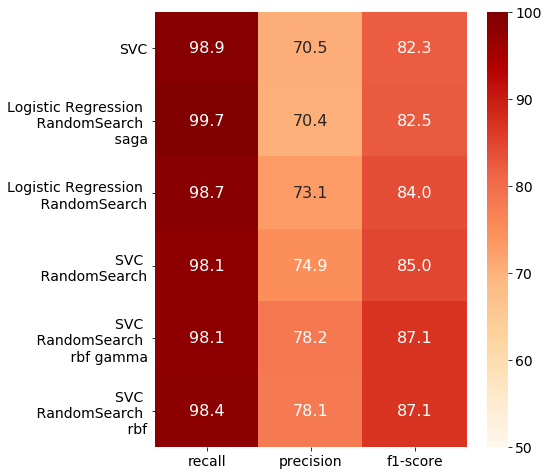

In [26]:
df_res = pd.DataFrame(result_dic)
for var in df_res.columns:
    if ('SMOTE' in var)|('smote' in var)|('_No' in var)|('Important' in var):
        df_res.drop(var,axis=1,inplace=True)
df_sort = df_res.iloc[:,np.argsort(df_res.loc['f1-score',:])]
plt.figure(figsize=(7,8))

#sns.heatmap(df_res[['GaussianNB','ComplementNB','LogisticRegression','RandomSearch_LogReg','SVC','RandomSearch_SVC','RandomSearch_SVC_rbf']]*100,annot=True,cmap='OrRd',fmt='.1f')
sns.heatmap(df_sort.loc[['recall','precision','f1-score'],df_sort.columns[-6:]].transpose()*100,annot=True,cmap='OrRd',fmt='.1f',vmin=50,vmax=100)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.gca().set_yticklabels(ticklabel)

plt.savefig('../plots/Extended_Top6.png')

**Out of the Top 6, 4 are SVC's.**

## Random Forest Classifier

Having investigated different models and data set sampling, let's now continue with ensemble modeling. The first model to investigate is the Random Forest Classifier.

In [14]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_estimators=250)
t_start = time.time()
rfc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
t_start = time.time()
ypredict = rfc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomForest'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  63.82076334953308
Time to predict:  0.31267619132995605
The accuracy is 0.977, meaning that 97.7% of the data was predicted right.
The recall is 0.788, meaning that 78.8% of errors were predicted right.
The precision is 0.760, meaning that only 76.0% of the predicted errors were actual errors.
The f1 score is 0.773.


These results don't look as good as what we had before. Let's see if it is only a question of hyperparameter tuning and whether RandomizedSearchCV will improve this result.

In [15]:
rfc = RandomForestClassifier(random_state=42,n_estimators=250,bootstrap=True)

cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
params = { 'max_depth':[6,12,None],'max_features':[6,9,12],'min_samples_split':[2,5,8]}
rand_rfc = RandomizedSearchCV(estimator=rfc,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1',verbose=True)
t_start = time.time()
rand_rfc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
print('Best parameters are: ', rand_rfc.best_params_)
t_start = time.time()
ypredict = rand_rfc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandSearch_RandomForest'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/lhw/DSproject/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lhw/DSproject/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lhw/DSproject/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lhw/DSproject/l

Time to fit:  2091.3559231758118
Best parameters are:  {'min_samples_split': 8, 'max_features': 6, 'max_depth': None}
Time to predict:  0.9488394260406494
The accuracy is 0.977, meaning that 97.7% of the data was predicted right.
The recall is 0.751, meaning that 75.1% of errors were predicted right.
The precision is 0.775, meaning that only 77.5% of the predicted errors were actual errors.
The f1 score is 0.763.


**This is not convincing and we will not investigate RandomForests anymore.** Additionally, the algorithm can't deal well with the sparse matrix.

## Data Wrangling (Part II)
From the above results we can see that the hyperparameter tuning lead to a significant improvement with the Support Vector Machine using Radial Basis Function Kernel achieving the best predictions. In the following we will investigate whether a more balanced data set would improve the predictability of the models.

## Resampling of the data

Just as a reminder: The reason for this is the **strongly imbalanced data set with less than 5% of the data being errors**.

### SMOTE

In [33]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)
Xtrain_res, ytrain_res = sm.fit_sample(Xtrain, ytrain.ravel())

Check out what effect this has on the data distribution of the ordinal, numerical and binary data.

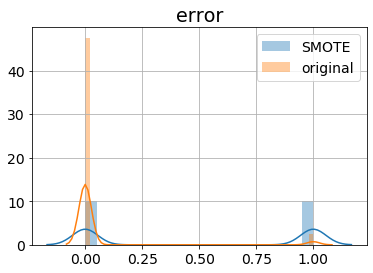

In [34]:
sns.distplot(ytrain_res,label='SMOTE') 
sns.distplot(ytrain,label='original') 
plt.legend(fontsize=14)
plt.grid()
plt.title('error')
plt.savefig('../plots/SMOTE_error.png')

The resampling produced a data set with equal number of true and false errors. 

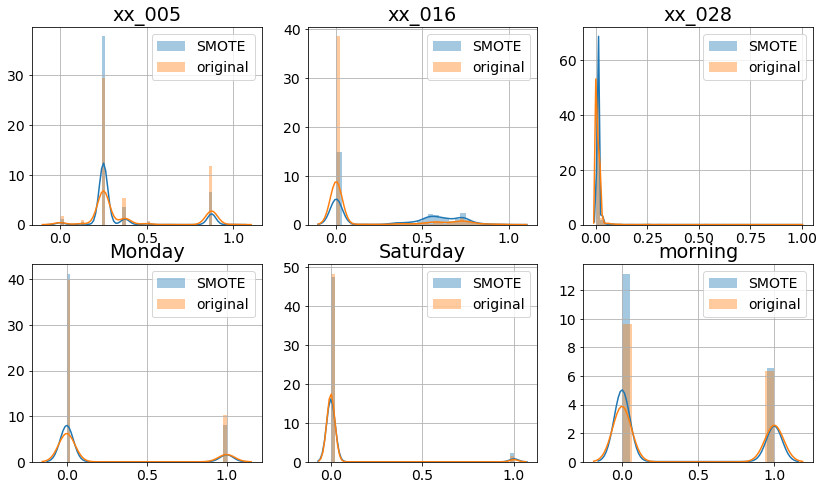

In [59]:
label_type = '_Acro' # '' #
plt.figure(figsize=(14,8))
k=1
for var in ['xx_005','xx_016','xx_028','Monday','Saturday','morning']:
    ind = np.where(columns==var)[0][0]
    if ind >np.where(columns=='error')[0]:
        ind-=1
    plt.subplot(2,3,k)
    ax1 = sns.distplot(Xtrain_res[:,ind].todense(),label='SMOTE',norm_hist=True) 
    ax2 = sns.distplot(Xtrain[:,ind].todense(),label='original',norm_hist=True)
    plt.legend(fontsize=14)
    plt.grid()
    if (label_type == '_Acro') | ('_' not in var):
        plt.title(var)
    else:
        plt.title(feature_def(var))
    k+=1
plt.savefig('../plots/Data_extra_SMOTE_6{}.png'.format(label_type))

The ordinal *xx_005* still sticks to the discrete values (standardized here) with a shift towards the 3rd place. The *xx_016* is less likely to be zero as does *xx_028*. Features representing days and times reveal that compared to the original data set it is **less likely to have data on Monday or in the morning, and more likely to have data on Saturday**. This suggests that **errors rather occur later in the day and in the weekend**.

In [18]:
from sklearn.svm import SVC
method = 'SVC_rbf_SMOTE'
c = 28.45445387731721
svc_smote = SVC(random_state=42,class_weight='balanced',C=c)
t_start = time.time()
svc_smote.fit(Xtrain_res,ytrain_res)
print('Time to fit: ',time.time()-t_start)
# Predict
t_start = time.time()
ypredict = svc_smote.predict(Xtest)
print('Time to predict: ',time.time()-t_start)

result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  80.7909791469574
Time to predict:  3.428589344024658
The accuracy is 0.984, meaning that 98.4% of the data was predicted right.
The recall is 0.973, meaning that 97.3% of errors were predicted right.
The precision is 0.769, meaning that only 76.9% of the predicted errors were actual errors.
The f1 score is 0.859.


In [19]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1.5e1,b=3e1)}
cv = 10
svc = SVC(random_state=42,class_weight='balanced')
rand_svc_smote = RandomizedSearchCV(estimator=svc,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1',verbose=True)
t_start = time.time()
rand_svc_smote.fit(Xtrain_res,ytrain_res)
print('Time to fit: ',time.time()-t_start)
print('Best parameters are: ', rand_svc_smote.best_params_)
t_start = time.time()
ypredict = rand_svc_smote.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomSearch_SVC_rbf_smote'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 124.1min finished


Time to fit:  7529.902170658112
Best parameters are:  {'C': 29.720342764546768}
Time to predict:  3.2566590309143066
The accuracy is 0.985, meaning that 98.5% of the data was predicted right.
The recall is 0.973, meaning that 97.3% of errors were predicted right.
The precision is 0.771, meaning that only 77.1% of the predicted errors were actual errors.
The f1 score is 0.860.


In [20]:
from sklearn.linear_model import LogisticRegression
c = 23.17234813747275
logreg_smote = LogisticRegression(random_state=42,class_weight='balanced',max_iter=100000,C=c)
logreg_smote.fit(Xtrain_res,ytrain_res)
ypredict = logreg_smote.predict(Xtest)
method = 'LogisticRegression_SMOTE'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

The accuracy is 0.982, meaning that 98.2% of the data was predicted right.
The recall is 0.987, meaning that 98.7% of errors were predicted right.
The precision is 0.732, meaning that only 73.2% of the predicted errors were actual errors.
The f1 score is 0.841.


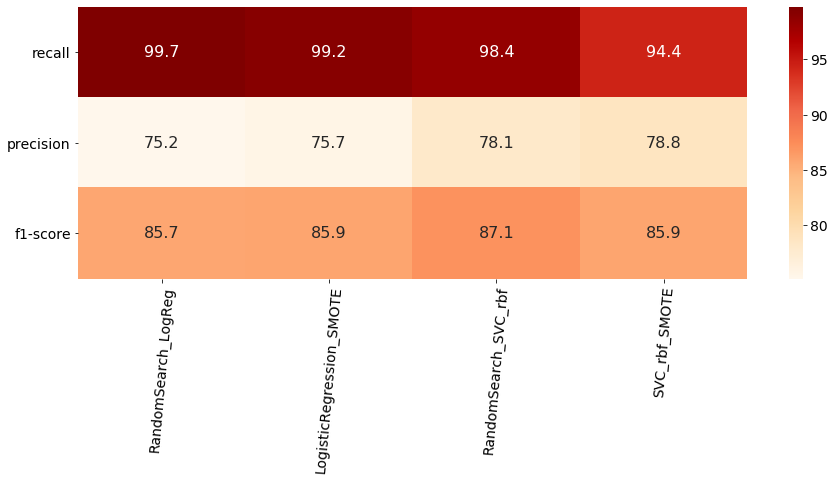

In [16]:
df_res = pd.DataFrame(result_dic)
plt.figure(figsize=(15,5))
#sns.heatmap(df_res[['GaussianNB','ComplementNB','LogisticRegression','RandomSearch_LogReg','SVC','RandomSearch_SVC',]]*100,annot=True,cmap='OrRd',fmt='.1f')
sns.heatmap(df_res.loc[['recall','precision','f1-score'],['RandomSearch_LogReg','LogisticRegression_SMOTE','RandomSearch_SVC_rbf','SVC_rbf_SMOTE']]*100,annot=True,cmap='OrRd',fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=85)
plt.show()

The above heatmap shows two interesting outcomes: SMOTE improves the performance of the LogisticRegression model, but does not improve SupportVectorMachine Classifier even though resampling with SMOTE does slightly improve precision. Simultaneously, resampling also worsens recall leading to a lower f1-score compared to SVC with the imbalanced data set. Interestingly, all 3 models perform basically the same with the SMOTE data set. It appears that 85.9 is the maximum achievable f1-score. 

**Again, the Support Vector Machine Classifier with a Radial Basis Function Kernel yields the best performance.**

## Most Important Features

In [28]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_estimators=250)
t_start = time.time()
rfc.fit(Xtrain,ytrain)
print('Time to fit: ',time.time()-t_start)
t_start = time.time()
ypredict = rfc.predict(Xtest)
print('Time to predict: ',time.time()-t_start)
method = 'RandomForest'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  68.13374614715576
Time to predict:  0.387371301651001
The accuracy is 0.977, meaning that 97.7% of the data was predicted right.
The recall is 0.788, meaning that 78.8% of errors were predicted right.
The precision is 0.760, meaning that only 76.0% of the predicted errors were actual errors.
The f1 score is 0.773.


In [29]:
imp = rfc.feature_importances_
cols = [i  for i in columns if i!='error']
order = np.argsort(imp)
df_imp = pd.DataFrame([cols[i] for i in order[::-1]],columns=['Feature'])
df_imp['Importance'] = np.round(imp[order]*100,2)[::-1]
df_imp.loc[df_imp['Importance']==0,'Feature']

685          id_001_345
686          id_001_540
687          id_001_367
688          id_001_414
689          id_001_821
             ...       
8149    id_026_399177.0
8150    id_026_399179.0
8151    id_026_399181.0
8152    id_026_399184.0
8153    id_026_407071.0
Name: Feature, Length: 7469, dtype: object

In [23]:
imp_pos = np.where(imp > 0)[0]
Xtrain_imp = Xtrain[:,imp_pos]
Xtest_imp = Xtest[:,imp_pos]
print('Before: ', Xtrain.shape, ' After: ',Xtrain_imp.shape)
print('Before: ', Xtest.shape, ' After: ',Xtest_imp.shape)

Before:  (30745, 8154)  After:  (30745, 5084)
Before:  (7687, 8154)  After:  (7687, 5084)


In [24]:
from sklearn.svm import SVC
method = 'SVC_rbf_Important'
c = 28.45445387731721
svc_imp = SVC(random_state=42,class_weight='balanced',C=c)
t_start = time.time()
svc_imp.fit(Xtrain_imp,ytrain)
print('Time to fit: ',time.time()-t_start)
# Predict
t_start = time.time()
ypredict = svc_imp.predict(Xtest_imp)
print('Time to predict: ',time.time()-t_start)
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  16.065508127212524
Time to predict:  2.4836766719818115
The accuracy is 0.984, meaning that 98.4% of the data was predicted right.
The recall is 0.984, meaning that 98.4% of errors were predicted right.
The precision is 0.763, meaning that only 76.3% of the predicted errors were actual errors.
The f1 score is 0.860.


This is a slightly less strong result as with the entire data set, because the recall is reduced. At least this tells us, that the 3151 features that were removed did only contribute little information for the SVC. Let's see if with the reduced noise the hyperparameter tuning leads to better prediction scores.

In [25]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import loguniform
params = {"C":loguniform(a=1.5e1,b=3e1),'gamma':loguniform(a=1e-3,b=1e0)}
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
svc = SVC(random_state=42,class_weight='balanced')
rand_svc_gamma_imp = RandomizedSearchCV(estimator=svc,param_distributions=params,n_jobs=-1,cv=cv,scoring=['f1','precision','recall'],refit='f1',verbose=True)
t_start = time.time()
rand_svc_gamma_imp.fit(Xtrain_imp,ytrain)
print('Time to fit: ',time.time()-t_start)
print('Best parameters are: ', rand_svc_gamma_imp.best_params_)
t_start = time.time()
ypredict = rand_svc_gamma_imp.predict(Xtest_imp)
print('Time to predict: ',time.time()-t_start)
method = 'RandomSearch_SVC_gamma_Important'
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 131.8min finished


Time to fit:  7922.647915124893
Best parameters are:  {'C': 20.164039871518593, 'gamma': 0.0288477833410745}
Time to predict:  2.40851092338562
The accuracy is 0.984, meaning that 98.4% of the data was predicted right.
The recall is 0.984, meaning that 98.4% of errors were predicted right.
The precision is 0.763, meaning that only 76.3% of the predicted errors were actual errors.
The f1 score is 0.860.


### Analyze the most important features

In [30]:
df_imp.head(20)

,Feature,Importance
0,xx_016,10.89
1,id_008_0101,5.99
2,id_004_0102,5.38
3,id_008_0110,2.64
4,xx_016_2,2.38
5,xx_016_0,2.20
6,ty_000_006,1.97
7,cl_003_6,1.83
8,id_006_0102,1.28
9,cl_008_unknown,1.09


In [44]:
bla = []
for var in df_imp['Feature']:
    if '_' in var:
        var0 = var.split('_')[0]+'_'+var.split('_')[1]
        new_var = feature_def(var0)
        if len(var.split('_'))==3:
            new_var = new_var+' '+var.split('_')[-1]
        bla.append(new_var)
    else:
        bla.append(var)
df_imp['True Feature'] = bla

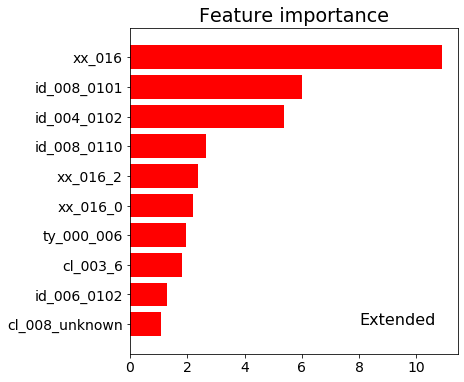

In [64]:
label_type = '_Acro' # '' #
plt.figure(figsize=(7,6))
plt.title("Feature importance")
plt.barh(range(10), df_imp.loc[9:0:-1,'Importance'].values,
       color="r")
if label_type == '_Acro':
    plt.yticks(range(10),df_imp.loc[9:0:-1,'Feature'] )
    plt.gcf().subplots_adjust(left=0.25)
else:
    plt.yticks(range(10),df_imp.loc[9:0:-1,'True Feature'] )
    plt.gcf().subplots_adjust(left=0.3)
plt.ylim([-1, 10])

plt.text(8,0,'Extended')
plt.savefig('../plots/FeatureImportance_ExtendedData{}.png'.format(label_type))

It is noticeable that Features that resulted from the Feature Engineering are in the top 20 Important Features. The question is now if they actually add significant value to the model prediction.

In [32]:
no_016c = np.where([True if 'xx_016_' not in var else False for var in cols])[0]
Xtrain_no016c = Xtrain[:,no_016c]
Xtest_no016c = Xtest[:,no_016c]
print('Before: ', Xtrain.shape, ' After: ',Xtrain_no016c.shape)
print('Before: ', Xtest.shape, ' After: ',Xtest_no016c.shape)


Before:  (30745, 8154)  After:  (30745, 8150)
Before:  (7687, 8154)  After:  (7687, 8150)


In [33]:
from sklearn.svm import SVC
method = 'SVC_rbf_No016Cluster'
c = 28.45445387731721
svc_no016c = SVC(random_state=42,class_weight='balanced',C=c)
t_start = time.time()
svc_no016c.fit(Xtrain_no016c,ytrain)
print('Time to fit: ',time.time()-t_start)
# Predict
t_start = time.time()
ypredict = svc_no016c.predict(Xtest_no016c)
print('Time to predict: ',time.time()-t_start)
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  19.852017641067505
Time to predict:  2.0626211166381836
The accuracy is 0.985, meaning that 98.5% of the data was predicted right.
The recall is 0.989, meaning that 98.9% of errors were predicted right.
The precision is 0.764, meaning that only 76.4% of the predicted errors were actual errors.
The f1 score is 0.862.


In [41]:
no_016c = np.where([True if 'xx_016_' not in var else False for var in cols])[0]
cols_noc = [var for var in cols if 'xx_016' not in var]
date_str = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','morning','afternoon','evening']
no_date = np.where([True if var not in date_str else False for var in cols_noc])[0]

Xtrain_noDate = Xtrain_no016c[:,no_date]
Xtest_noDate = Xtest_no016c[:,no_date]
print('Before: ', Xtrain.shape, ' After: ',Xtrain_noDate.shape)
print('Before: ', Xtest.shape, ' After: ',Xtest_noDate.shape)

Before:  (30745, 8154)  After:  (30745, 8141)
Before:  (7687, 8154)  After:  (7687, 8141)


In [42]:
from sklearn.svm import SVC
method = 'SVC_rbf_NoDate'
c = 28.45445387731721
svc_noDate = SVC(random_state=42,class_weight='balanced',C=c)
t_start = time.time()
svc_noDate.fit(Xtrain_noDate,ytrain)
print('Time to fit: ',time.time()-t_start)
# Predict
t_start = time.time()
ypredict = svc_noDate.predict(Xtest_noDate)
print('Time to predict: ',time.time()-t_start)
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  14.49213171005249
Time to predict:  1.575944185256958
The accuracy is 0.984, meaning that 98.4% of the data was predicted right.
The recall is 0.987, meaning that 98.7% of errors were predicted right.
The precision is 0.762, meaning that only 76.2% of the predicted errors were actual errors.
The f1 score is 0.860.


In [38]:
date_str = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','morning','afternoon','evening']
no_date2 = np.where([True if var not in date_str else False for var in cols])[0]

Xtrain_noDate2 = Xtrain[:,no_date2]
Xtest_noDate2 = Xtest[:,no_date2]
print('Before: ', Xtrain.shape, ' After: ',Xtrain_noDate2.shape)
print('Before: ', Xtest.shape, ' After: ',Xtest_noDate2.shape)

Before:  (30745, 8154)  After:  (30745, 8146)
Before:  (7687, 8154)  After:  (7687, 8146)


In [39]:
from sklearn.svm import SVC
method = 'SVC_rbf_NoDate2'
c = 28.45445387731721
svc_noDate2 = SVC(random_state=42,class_weight='balanced',C=c)
t_start = time.time()
svc_noDate2.fit(Xtrain_noDate2,ytrain)
print('Time to fit: ',time.time()-t_start)
# Predict
t_start = time.time()
ypredict = svc_noDate2.predict(Xtest_noDate2)
print('Time to predict: ',time.time()-t_start)
result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
update_results(result_dic[method],method,results_file)

Time to fit:  16.151893615722656
Time to predict:  1.86836838722229
The accuracy is 0.984, meaning that 98.4% of the data was predicted right.
The recall is 0.981, meaning that 98.1% of errors were predicted right.
The precision is 0.761, meaning that only 76.1% of the predicted errors were actual errors.
The f1 score is 0.857.


In [36]:
for feats in ['xx_016','id_008','id_004','id_006']:
    print(feats)
    no_var = np.where([True if feats not in var else False for var in cols])[0]
    Xtrain_novar = Xtrain[:,no_var]
    Xtest_novar = Xtest[:,no_var]
    print('Before: ', Xtrain.shape, ' After: ',Xtrain_novar.shape)
    print('Before: ', Xtest.shape, ' After: ',Xtest_novar.shape)
    method = 'SVC_rbf_No'+feats
    c = 28.45445387731721
    svc_novar = SVC(random_state=42,class_weight='balanced',C=c)
    t_start = time.time()
    svc_novar.fit(Xtrain_novar,ytrain)
    print('Time to fit: ',time.time()-t_start)
    # Predict
    t_start = time.time()
    ypredict = svc_novar.predict(Xtest_novar)
    print('Time to predict: ',time.time()-t_start)
    result_dic.update({method:score_func(ypredict,ytest,prt_info=True)})
    update_results(result_dic[method],method,results_file)

xx_016
Before:  (30745, 8154)  After:  (30745, 8149)
Before:  (7687, 8154)  After:  (7687, 8149)
Time to fit:  21.618116855621338
Time to predict:  2.7928478717803955
The accuracy is 0.985, meaning that 98.5% of the data was predicted right.
The recall is 0.989, meaning that 98.9% of errors were predicted right.
The precision is 0.764, meaning that only 76.4% of the predicted errors were actual errors.
The f1 score is 0.862.
id_008
Before:  (30745, 8154)  After:  (30745, 7517)
Before:  (7687, 8154)  After:  (7687, 7517)
Time to fit:  29.580561637878418
Time to predict:  3.3640384674072266
The accuracy is 0.980, meaning that 98.0% of the data was predicted right.
The recall is 0.976, meaning that 97.6% of errors were predicted right.
The precision is 0.715, meaning that only 71.5% of the predicted errors were actual errors.
The f1 score is 0.825.
id_004
Before:  (30745, 8154)  After:  (30745, 7309)
Before:  (7687, 8154)  After:  (7687, 7309)
Time to fit:  26.92992091178894
Time to predi

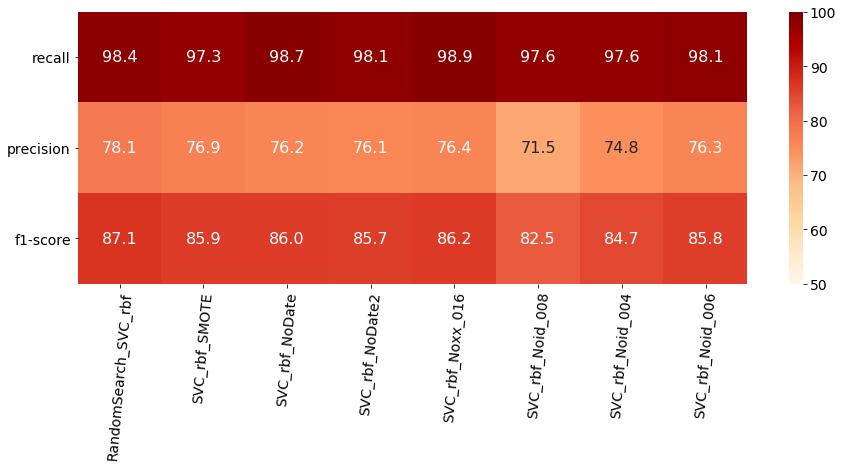

In [40]:
df_res = pd.DataFrame(result_dic)
plt.figure(figsize=(15,5))
#sns.heatmap(df_res[['GaussianNB','ComplementNB','LogisticRegression','RandomSearch_LogReg','SVC','RandomSearch_SVC',]]*100,annot=True,cmap='OrRd',fmt='.1f')
sns.heatmap(df_res.loc[['recall','precision','f1-score'],['RandomSearch_SVC_rbf','SVC_rbf_SMOTE','SVC_rbf_NoDate', 'SVC_rbf_NoDate2', 'SVC_rbf_Noxx_016', 'SVC_rbf_Noid_008', 'SVC_rbf_Noid_004', 'SVC_rbf_Noid_006']]*100,vmin=50,vmax=100,annot=True,cmap='OrRd',fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=85)
plt.show()


### Compare with other model runs

In [53]:
results_file2 = '../data/results_base2.db'
results2 = pd.read_sql('SELECT * FROM results','sqlite:///'+results_file2,index_col='score')
results2.drop('index',axis=1,inplace=True)
result_dic2 = results2.to_dict()
print(result_dic2.keys())

results_file1 = '../data/results_base_base.db'
results1 = pd.read_sql('SELECT * FROM results','sqlite:///'+results_file1,index_col='score')
results1.drop('index',axis=1,inplace=True)
result_dic1 = results1.to_dict()
print(result_dic1.keys())

dict_keys(['ComplementNB', 'LogisticRegression', 'GridSearch_LogReg', 'RandomSearch_LogReg', 'SVC', 'RandomForest', 'LogisticRegression_SMOTE'])
dict_keys(['LogisticRegression_Base', 'RandomSearch_LogReg_Base', 'RandomForest_base', 'LogisticRegression_SMOTE_base'])


In [54]:
combi_dic = {'Base Data \n Logistic Regression':result_dic1['RandomSearch_LogReg_Base']}
combi_dic.update({'BasePlus Data (SMOTE) \n Logistic Regression':result_dic2['LogisticRegression_SMOTE']})
combi_dic.update({'Extended Data \n SVC':result_dic['RandomSearch_SVC_rbf']})



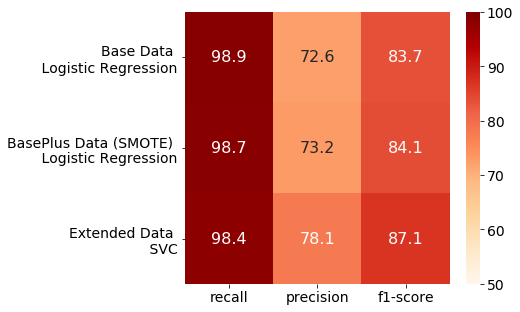

In [57]:
df_res = pd.DataFrame(combi_dic)
plt.figure(figsize=(8,5))
#sns.heatmap(df_res[['GaussianNB','ComplementNB','LogisticRegression','RandomSearch_LogReg','SVC','RandomSearch_SVC',]]*100,annot=True,cmap='OrRd',fmt='.1f')
sns.heatmap(df_res.loc[['recall','precision','f1-score'],:].transpose()*100,annot=True,cmap='OrRd',fmt='.1f',vmin=50,vmax=100,)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.gcf().subplots_adjust(left=0.325)
plt.savefig('../plots/Heatmap_3DataSets.png')


In [98]:
df_res.transpose()

,accuracy,f1-score,precision,recall
Base Data,0.981137,0.837262,0.725681,0.989390
BasePlus Data,0.981527,0.839729,0.730845,0.986737
Extended Data,0.985915,0.870892,0.781053,0.984085
